In [24]:
import xgboost as xgb
import numpy as np
import pandas as pd
import time
import pickle
import os
from math import log
import matplotlib.pyplot as plt
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,KFold, ParameterGrid,StratifiedKFold, cross_val_score

from sklearn import metrics 
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, brier_score_loss, f1_score, log_loss,auc,roc_curve,auc

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA
#from sklearn.utils.fixes import signature

from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [25]:
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Corpus Classification")

In [26]:
df = pd.read_excel(os.getcwd()+r"\Data Files\New Categories\Corpus_Sucrose.xlsx", encoding = 'unicode_escape')

In [27]:
df.head()

,spend_group,spend_cat_raw_l1,spend_cat_raw_l2,spend_cat_raw_l3,spend_cat_raw_l4,spend_cat_raw_l5,material_group_master_data,material_group_master_data_desc,material,material_desc,...,account_number,account_number_desc,cost_center,cost_center_desc,invoice_amount,invoice_amt_rep_curr_mth_rate,label_l2,label_l3,label_l4,label_l5
0,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,Not assigned,R66,Sugar (Sucrose),43852398,Sugar White Fine 0.1-0.42mm 25kg Bag,...,N001/#,N001/Not assigned,0039/#,0039/Not assigned,65760.09,72274.67,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,NaN
1,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,Not assigned,R66,Sugar (Sucrose),43993609,Sugar White ICUMSA20 035-045mm Big Bag,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,113915.60,24844.18,Suc/ Solid,Suc/Sol/ White,Suc/Sol/ White,NaN
2,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Not assigned,Not assigned,R66,Sugar (Sucrose),20340577,Sugar White Coarse ICUMSA200 50kg,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,963705.53,235695.07,Suc/ Solid,Suc/Sol/ White,NaN,NaN
3,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Not assigned,Not assigned,R66,Sugar (Sucrose),20340577,Sugar White Coarse ICUMSA200 50kg,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,7369433.59,1742528.74,Suc/ Solid,Suc/Sol/ White,NaN,NaN
4,Raw,Sucrose,Suc/ Solid,Suc/Sol/ White,Not assigned,Not assigned,R66,Sugar (Sucrose),20340577,Sugar White Coarse ICUMSA200 50kg,...,N001/#,N001/Not assigned,0028/#,0028/Not assigned,28585.16,7786.24,Suc/ Solid,Suc/Sol/ White,NaN,NaN


In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df["label_l2"])
df["label_l2_enc"]=le.transform(df["label_l2"])


# df["label_l2_enc"]=pd.get_dummies(df['label_l2']).values

In [85]:
x_column = ["material_descr_from_po","vendor_desc","account_number_desc","cost_center_desc"]
y_column = ["label_l2_enc"]
seed = 30

In [86]:
df.label_l2.value_counts()

Suc/ Solid      830
Suc/ Liquid      98
Suc/ Caramel      5
Name: label_l2, dtype: int64

In [87]:
X_train_1, X_test, y_train_1, y_test = train_test_split(df[x_column], df[y_column], test_size=0.2, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, test_size=0.2, random_state=seed)

In [88]:
print(y_train.label_l2_enc.value_counts())
print(y_valid.label_l2_enc.value_counts())
print(y_test.label_l2_enc.value_counts())


2    533
1     61
0      2
Name: label_l2_enc, dtype: int64
2    127
1     21
0      2
Name: label_l2_enc, dtype: int64
2    170
1     16
0      1
Name: label_l2_enc, dtype: int64


In [89]:
X_train.reset_index(inplace = True)
X_test.reset_index(inplace = True)
X_valid.reset_index(inplace = True)


In [90]:
print("Train sample : %.0f "% (X_train.shape[0]))
print("Valid sample : %.0f "% (X_valid.shape[0]))
print("Test sample : %.0f "% (X_test.shape[0]))

Train sample : 596 
Valid sample : 150 
Test sample : 187 


In [91]:
from sklearn.feature_extraction.text import CountVectorizer

for selected_col in x_column:
    sentences_train = X_train[selected_col].values
    sentences_valid = X_valid[selected_col].values
    sentences_test = X_test[selected_col].values

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)

    X_train = X_train.merge(pd.DataFrame(vectorizer.transform(sentences_train).toarray()),left_index=True, right_index = True)
    X_valid = X_valid.merge(pd.DataFrame(vectorizer.transform(sentences_valid).toarray()),left_index=True, right_index = True)
    X_test  = X_test.merge(pd.DataFrame(vectorizer.transform(sentences_test).toarray()),left_index=True, right_index = True)

In [92]:
all_col = list(X_train.columns)

In [93]:
all_col.remove('index')
all_col.remove('material_descr_from_po')
all_col.remove('vendor_desc')
all_col.remove('account_number_desc')
all_col.remove('cost_center_desc')

In [94]:
from keras.utils import to_categorical

# LSTM Model 

In [95]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

In [96]:
model.compile(loss='categorical_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                8920      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 8,953
Trainable params: 8,953
Non-trainable params: 0
_________________________________________________________________


In [97]:
history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=100,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=50)

In [98]:
loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Valid Accuracy:  0.9800
Testing Accuracy:  0.9840


In [99]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

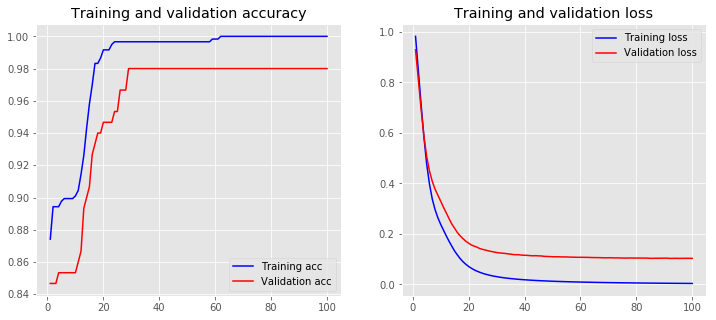

In [100]:
plot_history(history)

# Hyperparameter Tuning

In [101]:
def create_model(learning_rate=0.01, activation='relu'):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr=learning_rate)
  
    # Create your binary classification model  
    model = Sequential()
    model.add(layers.Dense(10, input_dim=input_dim, activation=activation))
    model.add(layers.Dense(3, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer = opt,
                  loss = 'categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [102]:
params = {'activation': ["relu", "tanh"],
          'batch_size': [16, 32, 64], 
          'epochs': [10,20,30],
          'learning_rate': [0.01, 0.001, 0.0001]}

In [103]:
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(build_fn = create_model,
                       verbose = 1)

In [106]:
random_search = RandomizedSearchCV(model,
                                   param_distributions = params, random_state = 10, n_iter = 20,
                                   cv = KFold(3), error_score=0, return_train_score =True)



In [107]:
print("Randomized search..")
search_time_start = time.time()
random_search.fit(X_train[all_col], to_categorical(y_train))
print("Randomized search time:", time.time() - search_time_start)

Randomized search..
Epoch 1/10
397/397 [==============================] - 0s 681us/step - loss: 1.0741 - accuracy: 0.4987
Epoch 2/10
397/397 [==============================] - 0s 48us/step - loss: 1.0684 - accuracy: 0.5239
Epoch 3/10
397/397 [==============================] - 0s 75us/step - loss: 1.0629 - accuracy: 0.5793
Epoch 4/10
397/397 [==============================] - 0s 60us/step - loss: 1.0575 - accuracy: 0.6146
Epoch 5/10
397/397 [==============================] - 0s 63us/step - loss: 1.0520 - accuracy: 0.6499
Epoch 6/10
397/397 [==============================] - 0s 153us/step - loss: 1.0465 - accuracy: 0.6902
Epoch 7/10
397/397 [==============================] - 0s 153us/step - loss: 1.0408 - accuracy: 0.7078
Epoch 8/10
397/397 [==============================] - 0s 78us/step - loss: 1.0352 - accuracy: 0.7305
Epoch 9/10
397/397 [==============================] - 0s 70us/step - loss: 1.0293 - accuracy: 0.7683
Epoch 10/10
397/397 [==============================] - 0s 269us/step

398/398 [==============================] - 0s 178us/step - loss: 0.0506 - accuracy: 0.9925
Epoch 5/20
398/398 [==============================] - 0s 277us/step - loss: 0.0202 - accuracy: 0.9975
Epoch 6/20
398/398 [==============================] - 0s 87us/step - loss: 0.0123 - accuracy: 0.9975
Epoch 7/20
398/398 [==============================] - 0s 90us/step - loss: 0.0096 - accuracy: 0.9975
Epoch 8/20
398/398 [==============================] - 0s 80us/step - loss: 0.0079 - accuracy: 0.9975
Epoch 9/20
398/398 [==============================] - 0s 95us/step - loss: 0.0070 - accuracy: 0.9975
Epoch 10/20
398/398 [==============================] - 0s 92us/step - loss: 0.0060 - accuracy: 0.9975
Epoch 11/20
398/398 [==============================] - 0s 431us/step - loss: 0.0054 - accuracy: 0.9975
Epoch 12/20
398/398 [==============================] - 0s 679us/step - loss: 0.0049 - accuracy: 0.9975
Epoch 13/20
398/398 [==============================] - 0s 529us/step - loss: 0.0046 - accuracy:

Epoch 30/30
397/397 [==============================] - 0s 48us/step
Epoch 1/30
397/397 [==============================] - 0s 832us/step - loss: 1.0980 - accuracy: 0.4005
Epoch 2/30
397/397 [==============================] - 0s 111us/step - loss: 1.0808 - accuracy: 0.4987
Epoch 3/30
397/397 [==============================] - 0s 151us/step - loss: 1.0647 - accuracy: 0.5995
Epoch 4/30
397/397 [==============================] - 0s 88us/step - loss: 1.0495 - accuracy: 0.6927
Epoch 5/30
397/397 [==============================] - 0s 177us/step - loss: 1.0350 - accuracy: 0.7657
Epoch 6/30
397/397 [==============================] - 0s 175us/step - loss: 1.0213 - accuracy: 0.7985
Epoch 7/30
397/397 [==============================] - 0s 88us/step - loss: 1.0083 - accuracy: 0.8438
Epoch 8/30
397/397 [==============================] - 0s 168us/step - loss: 0.9963 - accuracy: 0.8539
Epoch 9/30
397/397 [==============================] - 0s 194us/step - loss: 0.9844 - accuracy: 0.8866
Epoch 10/30
397/

397/397 [==============================] - 0s 538us/step - loss: 0.1001 - accuracy: 0.9899
Epoch 17/20
397/397 [==============================] - 0s 95us/step - loss: 0.0896 - accuracy: 0.9950
Epoch 18/20
397/397 [==============================] - 0s 354us/step - loss: 0.0806 - accuracy: 0.9950
Epoch 19/20
397/397 [==============================] - 0s 425us/step - loss: 0.0728 - accuracy: 0.9950
Epoch 20/20
397/397 [==============================] - 0s 60us/step
Epoch 1/20
397/397 [==============================] - 0s 829us/step - loss: 0.9072 - accuracy: 0.6272
Epoch 2/20
397/397 [==============================] - 0s 292us/step - loss: 0.7133 - accuracy: 0.8992
Epoch 3/20
397/397 [==============================] - 0s 264us/step - loss: 0.6046 - accuracy: 0.8992
Epoch 4/20
397/397 [==============================] - 0s 190us/step - loss: 0.5011 - accuracy: 0.8992
Epoch 5/20
397/397 [==============================] - 0s 286us/step - loss: 0.4163 - accuracy: 0.8992
Epoch 6/20
397/397 [===

397/397 [==============================] - 0s 1ms/step - loss: 1.1315 - accuracy: 0.1562
Epoch 2/30
397/397 [==============================] - 0s 264us/step - loss: 1.0992 - accuracy: 0.3249
Epoch 3/30
397/397 [==============================] - 0s 225us/step - loss: 1.0705 - accuracy: 0.5365
Epoch 4/30
397/397 [==============================] - 0s 181us/step - loss: 1.0445 - accuracy: 0.6851
Epoch 5/30
397/397 [==============================] - 0s 476us/step - loss: 1.0201 - accuracy: 0.8136
Epoch 6/30
397/397 [==============================] - 0s 104us/step - loss: 0.9970 - accuracy: 0.8715
Epoch 7/30
397/397 [==============================] - 0s 117us/step - loss: 0.9741 - accuracy: 0.8892
Epoch 8/30
397/397 [==============================] - 0s 93us/step - loss: 0.9516 - accuracy: 0.8967
Epoch 9/30
397/397 [==============================] - 0s 204us/step - loss: 0.9290 - accuracy: 0.9018
Epoch 10/30
397/397 [==============================] - 0s 290us/step - loss: 0.9066 - accuracy: 

397/397 [==============================] - 0s 563us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 19/20
397/397 [==============================] - 0s 69us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 20/20
397/397 [==============================] - 0s 731us/step
Epoch 1/20
397/397 [==============================] - 0s 1ms/step - loss: 0.5679 - accuracy: 0.8589
Epoch 2/20
397/397 [==============================] - 0s 173us/step - loss: 0.2897 - accuracy: 0.8992
Epoch 3/20
397/397 [==============================] - 0s 168us/step - loss: 0.2019 - accuracy: 0.9068
Epoch 4/20
397/397 [==============================] - 0s 60us/step - loss: 0.1110 - accuracy: 0.9798
Epoch 5/20
397/397 [==============================] - 0s 173us/step - loss: 0.0623 - accuracy: 0.9975
Epoch 6/20
397/397 [==============================] - 0s 253us/step - loss: 0.0373 - accuracy: 0.9975
Epoch 7/20
397/397 [==============================] - 0s 71us/step - loss: 0.0249 - accuracy: 0.9975
Epoch 8/20
397/397 [========

397/397 [==============================] - 0s 80us/step - loss: 1.0887 - accuracy: 0.7305
Epoch 4/30
397/397 [==============================] - 0s 70us/step - loss: 1.0864 - accuracy: 0.7531
Epoch 5/30
397/397 [==============================] - 0s 136us/step - loss: 1.0840 - accuracy: 0.7733
Epoch 6/30
397/397 [==============================] - 0s 78us/step - loss: 1.0814 - accuracy: 0.7859
Epoch 7/30
397/397 [==============================] - 0s 90us/step - loss: 1.0787 - accuracy: 0.8086
Epoch 8/30
397/397 [==============================] - 0s 146us/step - loss: 1.0759 - accuracy: 0.8262
Epoch 9/30
397/397 [==============================] - 0s 63us/step - loss: 1.0729 - accuracy: 0.8413
Epoch 10/30
397/397 [==============================] - 0s 58us/step - loss: 1.0696 - accuracy: 0.8463
Epoch 11/30
397/397 [==============================] - 0s 63us/step - loss: 1.0660 - accuracy: 0.8539
Epoch 12/30
397/397 [==============================] - 0s 65us/step - loss: 1.0621 - accuracy: 0.8

397/397 [==============================] - 0s 141us/step
Epoch 1/20
397/397 [==============================] - 1s 2ms/step - loss: 1.0040 - accuracy: 0.7456
Epoch 2/20
397/397 [==============================] - 0s 181us/step - loss: 0.7271 - accuracy: 0.8992
Epoch 3/20
397/397 [==============================] - 0s 93us/step - loss: 0.4857 - accuracy: 0.8992
Epoch 4/20
397/397 [==============================] - 0s 106us/step - loss: 0.3184 - accuracy: 0.8992
Epoch 5/20
397/397 [==============================] - 0s 91us/step - loss: 0.2239 - accuracy: 0.9018
Epoch 6/20
397/397 [==============================] - 0s 153us/step - loss: 0.1693 - accuracy: 0.9144
Epoch 7/20
397/397 [==============================] - 0s 249us/step - loss: 0.1205 - accuracy: 0.9647
Epoch 8/20
397/397 [==============================] - 0s 136us/step - loss: 0.0858 - accuracy: 0.9849
Epoch 9/20
397/397 [==============================] - 0s 123us/step - loss: 0.0562 - accuracy: 0.9899
Epoch 10/20
397/397 [========

397/397 [==============================] - 0s 204us/step - loss: 1.1008 - accuracy: 0.3224
Epoch 5/20
397/397 [==============================] - 0s 377us/step - loss: 1.0916 - accuracy: 0.3854
Epoch 6/20
397/397 [==============================] - 0s 342us/step - loss: 1.0826 - accuracy: 0.4660
Epoch 7/20
397/397 [==============================] - 0s 372us/step - loss: 1.0738 - accuracy: 0.5239
Epoch 8/20
397/397 [==============================] - 0s 450us/step - loss: 1.0653 - accuracy: 0.5894
Epoch 9/20
397/397 [==============================] - 0s 281us/step - loss: 1.0570 - accuracy: 0.6700
Epoch 10/20
397/397 [==============================] - 0s 332us/step - loss: 1.0487 - accuracy: 0.7254
Epoch 11/20
397/397 [==============================] - 0s 171us/step - loss: 1.0406 - accuracy: 0.7834
Epoch 12/20
397/397 [==============================] - 0s 95us/step - loss: 1.0327 - accuracy: 0.8186
Epoch 13/20
397/397 [==============================] - 0s 221us/step - loss: 1.0248 - accur

397/397 [==============================] - 0s 759us/step - loss: 0.0607 - accuracy: 0.9950
Epoch 22/30
397/397 [==============================] - 0s 615us/step - loss: 0.0560 - accuracy: 0.9950
Epoch 23/30
397/397 [==============================] - 0s 636us/step - loss: 0.0517 - accuracy: 0.9950
Epoch 24/30
397/397 [==============================] - 0s 470us/step - loss: 0.0481 - accuracy: 0.9950
Epoch 25/30
397/397 [==============================] - 1s 1ms/step - loss: 0.0446 - accuracy: 0.9950
Epoch 26/30
397/397 [==============================] - 0s 769us/step - loss: 0.0417 - accuracy: 0.9975
Epoch 27/30
397/397 [==============================] - 1s 1ms/step - loss: 0.0389 - accuracy: 0.9975
Epoch 28/30
397/397 [==============================] - 1s 1ms/step - loss: 0.0365 - accuracy: 1.0000
Epoch 29/30
397/397 [==============================] - 1s 1ms/step - loss: 0.0344 - accuracy: 1.0000
Epoch 30/30
397/397 [==============================] - 0s 455us/step
Epoch 1/30
397/397 [====

397/397 [==============================] - 0s 104us/step - loss: 0.2765 - accuracy: 0.8866
Epoch 8/30
397/397 [==============================] - 0s 206us/step - loss: 0.2367 - accuracy: 0.8917
Epoch 9/30
397/397 [==============================] - 0s 251us/step - loss: 0.2005 - accuracy: 0.9018
Epoch 10/30
397/397 [==============================] - 0s 292us/step - loss: 0.1693 - accuracy: 0.9295
Epoch 11/30
397/397 [==============================] - 0s 111us/step - loss: 0.1402 - accuracy: 0.9572
Epoch 12/30
397/397 [==============================] - 0s 276us/step - loss: 0.1130 - accuracy: 0.9824
Epoch 13/30
397/397 [==============================] - 0s 367us/step - loss: 0.0914 - accuracy: 0.9950
Epoch 14/30
397/397 [==============================] - 0s 96us/step - loss: 0.0728 - accuracy: 0.9950
Epoch 15/30
397/397 [==============================] - 0s 457us/step - loss: 0.0582 - accuracy: 0.9950
Epoch 16/30
397/397 [==============================] - 0s 468us/step - loss: 0.0477 - ac

398/398 [==============================] - 0s 128us/step - loss: 0.0248 - accuracy: 0.9975
Epoch 25/30
398/398 [==============================] - 0s 117us/step - loss: 0.0230 - accuracy: 0.9975
Epoch 26/30
398/398 [==============================] - 0s 132us/step - loss: 0.0214 - accuracy: 0.9975
Epoch 27/30
398/398 [==============================] - 0s 106us/step - loss: 0.0200 - accuracy: 0.9975
Epoch 28/30
398/398 [==============================] - 0s 111us/step - loss: 0.0188 - accuracy: 0.9975
Epoch 29/30
398/398 [==============================] - 0s 131us/step - loss: 0.0177 - accuracy: 0.9975
Epoch 30/30
398/398 [==============================] - 0s 380us/step
Epoch 1/30
397/397 [==============================] - 0s 1ms/step - loss: 0.6980 - accuracy: 0.8363
Epoch 2/30
397/397 [==============================] - 0s 497us/step - loss: 0.2149 - accuracy: 0.9043
Epoch 3/30
397/397 [==============================] - 0s 673us/step - loss: 0.0903 - accuracy: 0.9849
Epoch 4/30
397/397 [=

398/398 [==============================] - 0s 139us/step - loss: 0.0063 - accuracy: 0.9975
Epoch 10/30
398/398 [==============================] - 0s 642us/step - loss: 0.0055 - accuracy: 0.9975
Epoch 11/30
398/398 [==============================] - 0s 427us/step - loss: 0.0047 - accuracy: 0.9975
Epoch 12/30
398/398 [==============================] - 0s 451us/step - loss: 0.0041 - accuracy: 0.9975
Epoch 13/30
398/398 [==============================] - 0s 496us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 14/30
398/398 [==============================] - 0s 533us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 15/30
398/398 [==============================] - 0s 430us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 16/30
398/398 [==============================] - 0s 506us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 17/30
398/398 [==============================] - 0s 290us/step - loss: 0.0021 - accuracy: 1.0000
Epoch 18/30
398/398 [==============================] - 0s 182us/step - loss: 0.0017 -

397/397 [==============================] - 0s 187us/step - loss: 0.0037 - accuracy: 0.9975
Epoch 27/30
397/397 [==============================] - 0s 244us/step - loss: 0.0035 - accuracy: 0.9975
Epoch 28/30
397/397 [==============================] - 0s 197us/step - loss: 0.0034 - accuracy: 0.9975
Epoch 29/30
397/397 [==============================] - 0s 226us/step - loss: 0.0033 - accuracy: 0.9975
Epoch 30/30
397/397 [==============================] - 0s 256us/step
Epoch 1/30
398/398 [==============================] - 1s 1ms/step - loss: 0.6373 - accuracy: 0.8216
Epoch 2/30
398/398 [==============================] - 0s 75us/step - loss: 0.2626 - accuracy: 0.9121
Epoch 3/30
398/398 [==============================] - 0s 242us/step - loss: 0.1712 - accuracy: 0.9246
Epoch 4/30
398/398 [==============================] - 0s 73us/step - loss: 0.1020 - accuracy: 0.9749
Epoch 5/30
398/398 [==============================] - 0s 79us/step - loss: 0.0539 - accuracy: 0.9975
Epoch 6/30
398/398 [======

397/397 [==============================] - 0s 224us/step - loss: 0.0292 - accuracy: 1.0000
Epoch 11/30
397/397 [==============================] - 0s 314us/step - loss: 0.0247 - accuracy: 1.0000
Epoch 12/30
397/397 [==============================] - 0s 229us/step - loss: 0.0215 - accuracy: 1.0000
Epoch 13/30
397/397 [==============================] - 0s 48us/step - loss: 0.0188 - accuracy: 1.0000
Epoch 14/30
397/397 [==============================] - 0s 143us/step - loss: 0.0167 - accuracy: 1.0000
Epoch 15/30
397/397 [==============================] - 0s 137us/step - loss: 0.0151 - accuracy: 1.0000
Epoch 16/30
397/397 [==============================] - 0s 65us/step - loss: 0.0137 - accuracy: 1.0000
Epoch 17/30
397/397 [==============================] - 0s 53us/step - loss: 0.0126 - accuracy: 1.0000
Epoch 18/30
397/397 [==============================] - 0s 143us/step - loss: 0.0116 - accuracy: 1.0000
Epoch 19/30
397/397 [==============================] - 0s 57us/step - loss: 0.0108 - acc

398/398 [==============================] - 0s 70us/step - loss: 0.0061 - accuracy: 1.0000
Epoch 29/30
398/398 [==============================] - 0s 152us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 30/30
398/398 [==============================] - 0s 40us/step
Epoch 1/30
397/397 [==============================] - 1s 1ms/step - loss: 1.0486 - accuracy: 0.4433
Epoch 2/30
397/397 [==============================] - 0s 264us/step - loss: 0.9106 - accuracy: 0.8715
Epoch 3/30
397/397 [==============================] - 0s 108us/step - loss: 0.7895 - accuracy: 0.8791
Epoch 4/30
397/397 [==============================] - 0s 338us/step - loss: 0.6736 - accuracy: 0.8841
Epoch 5/30
397/397 [==============================] - 0s 100us/step - loss: 0.5752 - accuracy: 0.8841
Epoch 6/30
397/397 [==============================] - 0s 168us/step - loss: 0.4960 - accuracy: 0.8892
Epoch 7/30
397/397 [==============================] - 0s 261us/step - loss: 0.4343 - accuracy: 0.8892
Epoch 8/30
397/397 [=======

398/398 [==============================] - 0s 184us/step - loss: 0.2288 - accuracy: 0.9121
Epoch 15/30
398/398 [==============================] - 0s 86us/step - loss: 0.2168 - accuracy: 0.9121
Epoch 16/30
398/398 [==============================] - 0s 434us/step - loss: 0.2052 - accuracy: 0.9196
Epoch 17/30
398/398 [==============================] - 0s 180us/step - loss: 0.1943 - accuracy: 0.9296
Epoch 18/30
398/398 [==============================] - 0s 193us/step - loss: 0.1844 - accuracy: 0.9347
Epoch 19/30
398/398 [==============================] - 0s 205us/step - loss: 0.1742 - accuracy: 0.9347
Epoch 20/30
398/398 [==============================] - 0s 283us/step - loss: 0.1650 - accuracy: 0.9422
Epoch 21/30
398/398 [==============================] - 0s 110us/step - loss: 0.1561 - accuracy: 0.9497
Epoch 22/30
398/398 [==============================] - 0s 99us/step - loss: 0.1477 - accuracy: 0.9548
Epoch 23/30
398/398 [==============================] - 0s 187us/step - loss: 0.1399 - a

Epoch 8/10
398/398 [==============================] - 0s 70us/step - loss: 0.4266 - accuracy: 0.9045
Epoch 9/10
398/398 [==============================] - 0s 325us/step - loss: 0.3883 - accuracy: 0.9045
Epoch 10/10
398/398 [==============================] - 0s 63us/step
Epoch 1/20
596/596 [==============================] - 1s 952us/step - loss: 0.9719 - accuracy: 0.5956
Epoch 2/20
596/596 [==============================] - 0s 44us/step - loss: 0.6063 - accuracy: 0.8993
Epoch 3/20
596/596 [==============================] - 0s 98us/step - loss: 0.2712 - accuracy: 0.8993
Epoch 4/20
596/596 [==============================] - 0s 110us/step - loss: 0.1593 - accuracy: 0.9178
Epoch 5/20
596/596 [==============================] - 0s 125us/step - loss: 0.0831 - accuracy: 0.9765
Epoch 6/20
596/596 [==============================] - 0s 115us/step - loss: 0.0370 - accuracy: 0.9950
Epoch 7/20
596/596 [==============================] - 0s 110us/step - loss: 0.0174 - accuracy: 0.9966
Epoch 8/20
596/59

In [108]:
print("Best Score: ",
      random_search.best_score_,
      "and Best Params: ",
      random_search.best_params_)

Best Score:  -0.09458806431358492 and Best Params:  {'learning_rate': 0.01, 'epochs': 20, 'batch_size': 64, 'activation': 'relu'}


Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 10)                8920      
_________________________________________________________________
dense_150 (Dense)            (None, 3)                 33        
Total params: 8,953
Trainable params: 8,953
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Valid Accuracy:  0.9800
Testing Accuracy:  0.9893


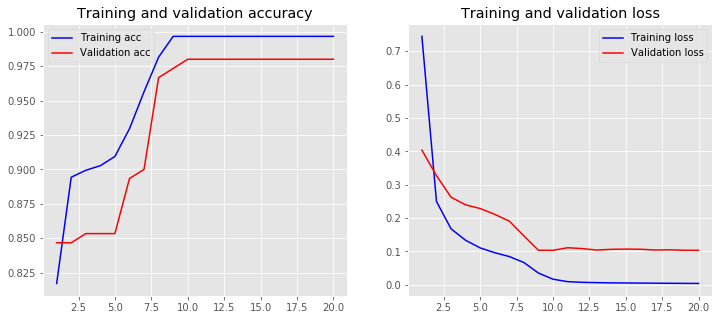

In [110]:
from keras.models import Sequential
from keras import layers

input_dim = X_train[all_col].shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))

opt = Adam(learning_rate = 0.01)

model.compile(loss='categorical_crossentropy', 
               optimizer=opt, 
               metrics=['accuracy'])
model.summary()

history = model.fit(X_train[all_col], to_categorical(y_train),
                     epochs=20,
                     verbose=False,
                     validation_data=(X_valid[all_col], to_categorical(y_valid)),
                     batch_size=64)

loss, accuracy = model.evaluate(X_train[all_col], to_categorical(y_train), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_valid[all_col], to_categorical(y_valid), verbose=False)
print("Valid Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test[all_col], to_categorical(y_test), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

# Model Evaluation: Test Data

In [111]:
score, acc = model.evaluate(X_test[all_col], to_categorical(y_test),
                       batch_size=16, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.9893048405647278


Confusion matrix, without normalization


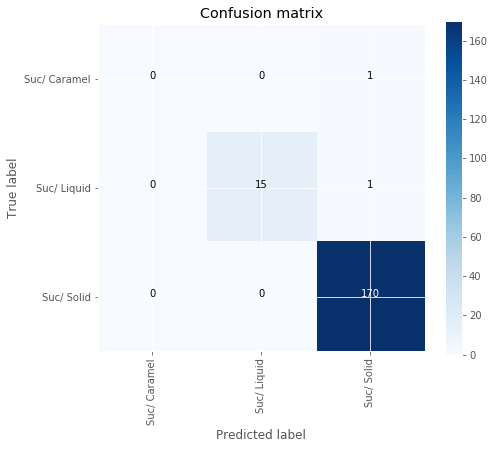

In [112]:
text_labels = le.classes_
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = pd.DataFrame(model.predict_classes(X_test[all_col]));
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(text_labels), normalize=False,
                      title='Confusion matrix')

fig.savefig("txt_classification_NN_BOW" + ".png", pad_inches=5.0)


In [113]:
from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test, y_pred)
cohen_score

0.9318637274549099

In [114]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred)


score_dic= {'Labels':text_labels,
           'precision':precision,
            'recall':recall,
            'fscore':fscore,
            'support':support
           }

pd.DataFrame(score_dic)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Labels,precision,recall,fscore,support
0,Suc/ Caramel,0.000000,0.0000,0.000000,1
1,Suc/ Liquid,1.000000,0.9375,0.967742,16
2,Suc/ Solid,0.988372,1.0000,0.994152,170


In [120]:
tmp = pd.DataFrame(data = cnf_matrix,index = text_labels, columns = text_labels)
tmp["total"] = tmp.sum(axis=1)
accuracy= {"Category":[],"Accuracy":[]}
for i in range(tmp.shape[0]):
    accuracy["Category"].append(tmp.index[i])
    accuracy["Accuracy"].append(tmp.iloc[i,i]/tmp.loc[tmp.index[i],"total"])

print("Accuracy:")
print(pd.DataFrame(accuracy))

Accuracy:
       Category  Accuracy
0  Suc/ Caramel    0.0000
1   Suc/ Liquid    0.9375
2    Suc/ Solid    1.0000


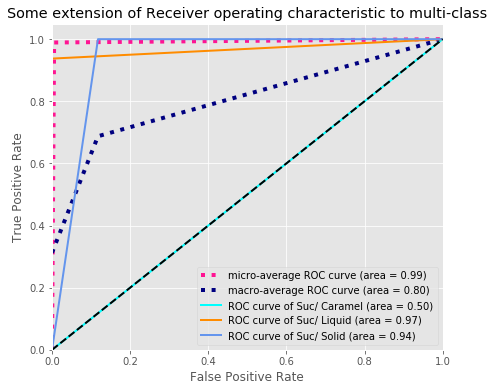

In [116]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

num_labels = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve((y_test==i), (y_pred == i))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure()
fig.set_size_inches(7, 6, forward=True)
# plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(text_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [117]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve((y_test==i), (y_pred == i))
    average_precision[i] = average_precision_score((y_test==i), (y_pred == i))

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(to_categorical(y_test).ravel(), to_categorical(y_pred).ravel())
average_precision["micro"] = average_precision_score(to_categorical(y_test), to_categorical(y_pred),
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.98


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.98')

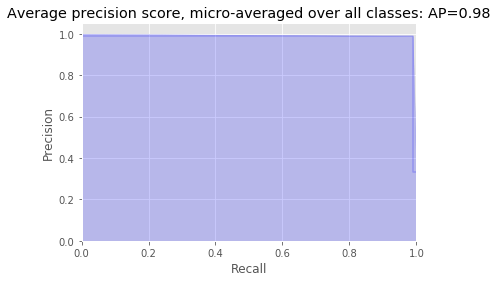

In [118]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

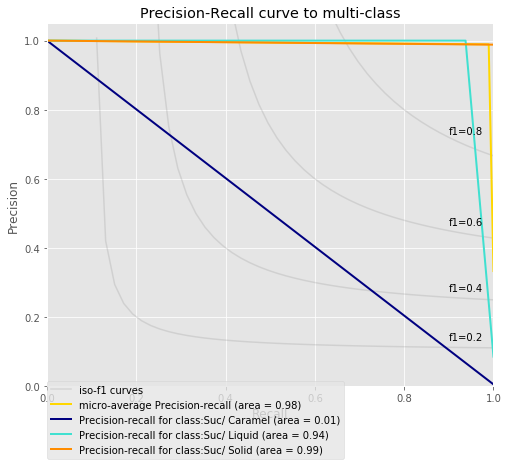

In [119]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(text_labels[i], average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()